In [1]:
import os
import torch
import matplotlib.pyplot as plt
from skimage.io import imread

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes

# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    TexturedSoftPhongShader
)

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))

from utils import image_grid

In [2]:
# Setup
device = torch.device("cuda:0")
torch.cuda.set_device(device)

# Set paths
DATA_DIR = "./data"
obj_filename = os.path.join(DATA_DIR, "cow_mesh/cow.obj")

# Load obj file
mesh = load_objs_as_meshes([obj_filename], device=device)
texture_image=mesh.textures.maps_padded()

/home/myaldiz/GitHub/pytorch3d/pytorch3d/io/obj_io.py:70: UserWarning: Faces have invalid indices
  warnings.warn("Faces have invalid indices")


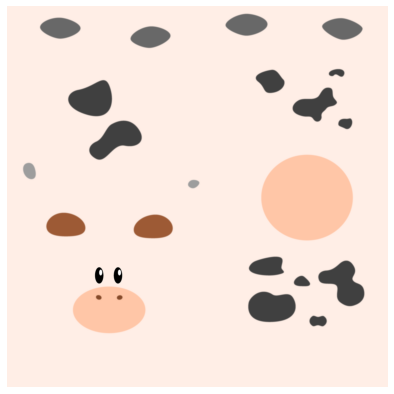

In [3]:
plt.figure(figsize=(7,7))
plt.imshow(texture_image.squeeze().cpu().numpy())
plt.grid("off");
plt.axis('off');

In [14]:
# Initialize an OpenGL perspective camera.
# With world coordinates +Y up, +X left and +Z in, the front of the cow is facing the -Z direction. 
# So we move the camera by 180 in the azimuth direction so it is facing the front of the cow. 
R, T = look_at_view_transform(2.7, 0, 180) 
cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. We also set bin_size and max_faces_per_bin to None which ensure that 
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
# the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size=512, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
)

# Place a point light in front of the object. As mentioned above, the front of the cow is facing the 
# -z direction. 
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

# Create a phong renderer by composing a rasterizer and a shader. The textured phong shader will 
# interpolate the texture uv coordinates for each vertex, sample from a texture image and 
# apply the Phong lighting model
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=TexturedSoftPhongShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
)

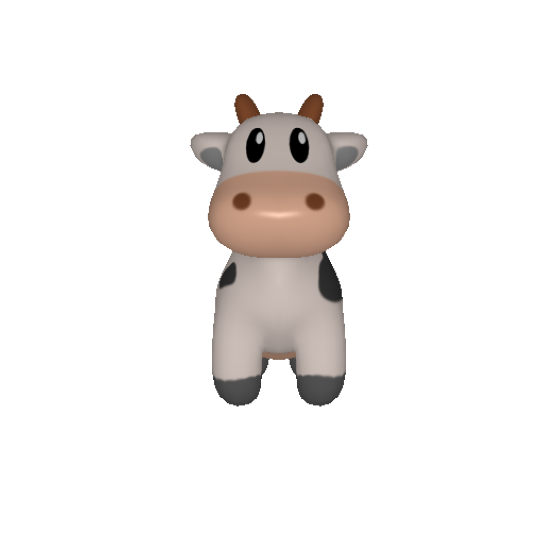

In [13]:
images = renderer(mesh)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off");
plt.axis("off");

In [22]:
from pytorch3d.renderer.blending import (
    BlendParams,
    softmax_rgb_blend)
from pytorch3d.renderer.lighting import PointLights
from pytorch3d.renderer.materials import Materials
from pytorch3d.renderer.mesh.texturing import (
    interpolate_texture_map, 
    interpolate_vertex_colors,
    interpolate_face_attributes)
from typing import Tuple
from torch import nn

In [23]:
def _apply_lighting(
    points, normals, lights, cameras, materials
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Args:
        points: torch tensor of shape (N, P, 3) or (P, 3).
        normals: torch tensor of shape (N, P, 3) or (P, 3)
        lights: instance of the Lights class.
        cameras: instance of the Cameras class.
        materials: instance of the Materials class.
    Returns:
        ambient_color: same shape as materials.ambient_color
        diffuse_color: same shape as the input points
        specular_color: same shape as the input points
    """
    light_diffuse = lights.diffuse(normals=normals, points=points)
    light_specular = lights.specular(
        normals=normals,
        points=points,
        camera_position=cameras.get_camera_center(),
        shininess=materials.shininess,
    )
    ambient_color = materials.ambient_color * lights.ambient_color
    diffuse_color = materials.diffuse_color * light_diffuse
    specular_color = materials.specular_color * light_specular
    if normals.dim() == 2 and points.dim() == 2:
        # If given packed inputs remove batch dim in output.
        return (
            ambient_color.squeeze(),
            diffuse_color.squeeze(),
            specular_color.squeeze(),
        )
    return ambient_color, diffuse_color, specular_color

In [24]:
def blinn_phong_shading(
    meshes, fragments, lights, cameras, materials, texels
) -> torch.Tensor:
    """
    Apply per pixel shading. First interpolate the vertex normals and
    vertex coordinates using the barycentric coordinates to get the position
    and normal at each pixel. Then compute the illumination for each pixel.
    The pixel color is obtained by multiplying the pixel textures by the ambient
    and diffuse illumination and adding the specular component.
    Args:
        meshes: Batch of meshes
        fragments: Fragments named tuple with the outputs of rasterization
        lights: Lights class containing a batch of lights
        cameras: Cameras class containing a batch of cameras
        materials: Materials class containing a batch of material properties
        texels: texture per pixel of shape (N, H, W, K, 3)
    Returns:
        colors: (N, H, W, K, 3)
    """
    verts = meshes.verts_packed()  # (V, 3)
    faces = meshes.faces_packed()  # (F, 3)
    vertex_normals = meshes.verts_normals_packed()  # (V, 3)
    faces_verts = verts[faces]
    faces_normals = vertex_normals[faces]
    pixel_coords = interpolate_face_attributes(
        fragments.pix_to_face, fragments.bary_coords, faces_verts
    )
    pixel_normals = interpolate_face_attributes(
        fragments.pix_to_face, fragments.bary_coords, faces_normals
    )
    ambient, diffuse, specular = _apply_lighting(
        pixel_coords, pixel_normals, lights, cameras, materials
    )
    colors = (ambient + diffuse) * texels + specular
    return colors

In [25]:
class TexturedSoftBlinnPhongShader(nn.Module):
    """
    Per pixel lighting applied to a texture map. First interpolate the vertex
    uv coordinates and sample from a texture map. Then apply the lighting model
    using the interpolated coords and normals for each pixel.
    The blending function returns the soft aggregated color using all
    the faces per pixel.
    To use the default values, simply initialize the shader with the desired
    device e.g.
    .. code-block::
        shader = TexturedPhongShader(device=torch.device("cuda:0"))
    """

    def __init__(
        self, device="cpu", cameras=None, lights=None, materials=None, blend_params=None
    ):
        super().__init__()
        self.lights = lights if lights is not None else PointLights(device=device)
        self.materials = (
            materials if materials is not None else Materials(device=device)
        )
        self.cameras = cameras
        self.blend_params = blend_params if blend_params is not None else BlendParams()

    def forward(self, fragments, meshes, **kwargs) -> torch.Tensor:
        cameras = kwargs.get("cameras", self.cameras)
        if cameras is None:
            msg = "Cameras must be specified either at initialization \
                or in the forward pass of TexturedSoftPhongShader"
            raise ValueError(msg)
        texels = interpolate_texture_map(fragments, meshes)
        lights = kwargs.get("lights", self.lights)
        materials = kwargs.get("materials", self.materials)
        blend_params = kwargs.get("blend_params", self.blend_params)
        colors = blinn_phong_shading(
            meshes=meshes,
            fragments=fragments,
            texels=texels,
            lights=lights,
            cameras=cameras,
            materials=materials,
        )
        images = softmax_rgb_blend(colors, fragments, blend_params)
        return images

In [27]:
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=TexturedSoftBlinnPhongShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
)

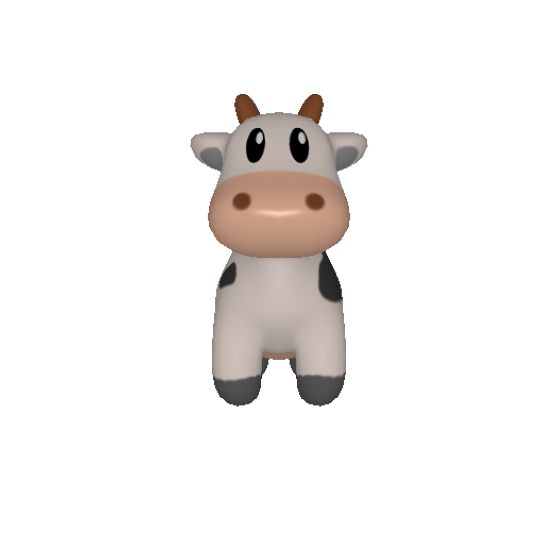

In [28]:
images = renderer(mesh)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off");
plt.axis("off");